In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)   

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'n in the Fe', u".\n* ''[[Con", u"oldier's so", u'\xf6hm-Bawerk ', u'tification,', u' warrior, a', u'uot; would ', u' 115       ', u'orbata acid', u'>\n      <co', u'ate, the co', u'other natio', u'ing the his', u'et bromine;', u' Christ&quo', u' average]] ', u' their home', u'ks and a ri', u'on]]/[[Joel', u' new era fo', u'aph that th', u' known as t', u's from the ', u'ast majorit', u'trips, thou', u'ent of regi', u'metric aspe', u'd named by ', u'Z</timestam', u'tude of 1 c', u'!&quot; [ht', u'o ==\n\n* [[D', u'[[Belarusia', u'iton]], Rus', u'ccessful si', u'es his theo', u' explain th', u' the South.', u'sing with a', u'd ball is h', u'e could des', u'[Friedrich ', u'th virtuall', u' foreign ac', u'variant in ', u'd and watch', u"t; ''[[Foot", u' became Lea', u'stern Europ', u' </contribu', u'ese terms n', u'arting in t', u'gence of th', u'of the cons', u'uickly swit', u', thus star', u'lly develop', u'g the offic', u'esult, the ', u'red HMMWV. ', u'ament is de', u'University ', 

In [6]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}


class random_memory_hint(MODEL):
    def swap_layer(self, 
                   inp_t,
                   state,
                   memory):
        X_t = tf.concat(1, [inp_t,
                            state,
                            memory])
        RES = tf.matmul(X_t, self.Matrix) + self.Bias
        state = tf.tanh(RES)
        return state
    
    def layer(self,
              inp_t,
              state):
        X_t = tf.concat(1, [inp_t,
                            state])
        RES = tf.matmul(X_t, self.Base_Matrix) + self.Base_Bias
        state = tf.tanh(RES)
        return state        

    
    def iteration(self, inp, state):
        output = self.layer(inp,
                            state[0])
        return output, [output, output]
    
    def swap_iteration(self, inp, state):
        output = self.swap_layer(inp,
                                 state[0],
                                 state[1])
        swap_prob = tf.constant(self._swap_prob) 
        swap = tf.less(tf.random_uniform([1])[0], swap_prob)
        memory = tf.cond(swap,
                         lambda: output,
                         lambda: state[1])  
        return output, [output, memory]
    
    def reduce_hint_matrix(self):
        return self.Hint_Matrix.assign(tf.constant(self._reducer) * self.Hint_Matrix)
    
    def dont_reduce(self):
        return self.Hint_Matrix
    
    def unrollings(self, train_inputs, state):
        outputs = list()
        for inp in train_inputs:
            output, state = self.iteration(inp, state)
            outputs.append(output)  
        return [tf.concat(0, outputs), tf.concat(0, state)]
    
    def swap_unrollings(self, train_inputs, state):
        outputs = list()
        reduce_operation = tf.cond(self.disable_hint,
                                             lambda: self.reduce_hint_matrix(),
                                             lambda: self.dont_reduce())
        with tf.control_dependencies([reduce_operation]):
            for inp in train_inputs:
                output, state = self.swap_iteration(inp, state)
                outputs.append(output)        
        return [tf.concat(0, outputs), tf.concat(0, state)]    
    
    def optimizer_with_hint(self):
        gradients, v = zip(*self.Optimizer.compute_gradients(self._loss,
                                                             var_list=self.all_trainable))
        gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
        """optimizer"""
        optimizer_apply = self.Optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)  
        return optimizer_apply
    
    def optimizer_without_hint(self):
        gradients, v = zip(*self.Optimizer.compute_gradients(self._loss,
                                                             var_list=self.all_trainable[:-1]))
        gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
        """optimizer"""
        optimizer_apply = self.Optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)  
        return optimizer_apply
    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 swap_prob,
                 disable,
                 reducer,
                 train_text,
                 valid_text):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._swap_prob = swap_prob
        self._disable = list(disable)
        self._reducer = reducer
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "swap_prob": 8,
                         "disable": 9,
                         "reducer": 10,
                         "type": 11}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Base_Matrix = tf.Variable(
                    tf.truncated_normal([self._vocabulary_size + self._num_nodes[0], self._num_nodes[0]],
                                        stddev=0.1))
                self.Base_Bias = tf.Variable(tf.zeros([self._num_nodes[0]]))
                self.Hint_Matrix = tf.Variable(
                    tf.truncated_normal([self._num_nodes[0], self._num_nodes[0]],
                                        stddev=0.1))

                self.Matrix = tf.concat(0, [self.Base_Matrix, self.Hint_Matrix])
                self.Bias = self.Base_Bias
                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = [tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False),
                               tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False)]
                
                """global step"""
                self._global_step = tf.Variable(0)

                swap = tf.less(self._global_step, tf.constant(self._disable[1])) 
                self.disable_hint = tf.logical_and(swap, tf.greater_equal(self._global_step, tf.constant(self._disable[0])))

                state = saved_state
                [outputs, state] = tf.cond(swap,
                                                   lambda: self.swap_unrollings(train_inputs, state),
                                                   lambda: self.unrollings(train_inputs, state))
                state = tf.split(0, 2, state)

                save_list = list()
                
                save_list.append(saved_state[0].assign(state[0]))
                save_list.append(saved_state[1].assign(state[1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)
                
                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(outputs, weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels)))
                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(0.5,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                """all_trainable"""
                self.all_trainable = [self.Base_Matrix, self.Base_Bias, weights, bias, self.Hint_Matrix]
                """Optimizer"""
                self.Optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)

                """optimizer"""
                self._optimizer = tf.cond(tf.logical_and(self.swap_regime,
                                                         tf.logical_not(self.disable_hint)),
                                          self.optimizer_with_hint,
                                          self.optimizer_without_hint)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                reset_list.append(saved_sample_state[0].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[1].assign(tf.zeros([1, self._num_nodes[0]])))

                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                [sample_outputs, sample_state] = tf.cond(swap,
                                                          lambda: self.swap_unrollings([self._sample_input], saved_sample_state),
                                                          lambda: self.unrollings([self._sample_input], saved_sample_state))                
                sample_state = tf.split(0, 2, sample_state)
                sample_output = sample_outputs
                sample_save_list = list()
                sample_save_list.append(saved_sample_state[0].assign(sample_state[0]))
                sample_save_list.append(saved_sample_state[1].assign(sample_state[1]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(list(self._num_nodes))
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._swap_prob)
        metadata.append(list(self._disable))
        metadata.append(self._reducer)
        metadata.append('random_memory_hint')
        return metadata
  

In [15]:

model = random_memory_hint(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 10,
                 1,
                 [128],
                 0.2,
                           [19000, 19001],
                           0.997,
                 train_text,
                 valid_text)

In [16]:
model.run(30,
          0.9,
            100,
            200,
            3,
            5,
            100,
          print_intermediate_results = True)

Initialized
Average loss at step 0: 5.345987 learning rate: 0.500000
Percentage_of correct: 0.00%
tI³µ«5°ÃÊQvÿð_CvE.B¡Ô!	d¥|üå7Jrú!"ªöIRÆ×óÇ]á'øSK
wÞ³oRúç³n°1;W¶NÅh¤°Ú¹ÏÝmdåPmÖ
Ê6Õñm)¬nÆµØè'Í´±ÍlG¨,!bOZ!be&æ]®¸Wt¯p®GQ]sm>Å ?°Ï¬µRæ3·ÅºåaþAR3ÍªJì«Æò±'³2þÏ¯s@
|ê6+ttYèJáÙòAÚG·#	cË³§ª·*ÏzamÓéØÔÛæhr?ú~¶tS?º%ÛØ Ñÿ/é±öö] øCku¡¹3Æ~¬ìÃ*yÑe¾%
L2GD³í`¦#7y¡üåpZk¥£MD{ ¥ïo««mHû_¡ö²-VqsF$« ¶-(ì)qÙùÃ>@$Á~eS«fYò`Yæñ)oØ}¶§js@, ÙQ
¸C£X_¥ràËÃ*'©Îiç Ðq5 OEòRsÔó/z\X$öA²"z¾©¨¤9Ïû EUavJ+ºËMå"'$ÎFýfÎ <VÁéb¤¬%|h(«73*
Validation percentage of correct: 0.49%

Average loss at step 500: 4.165558 learning rate: 0.500000
Percentage_of correct: 14.78%
Validation percentage of correct: 14.73%

Average loss at step 1000: 3.926748 learning rate: 0.450000
Percentage_of correct: 18.25%
Validation percentage of correct: 18.35%

Average loss at step 1500: 3.869342 learning rate: 0.405000
Percentage_of correct: 20.68%
Validation percentage of correct: 22.50%

Average loss at step 2000: 3.802954 learning rate: 0.364500
P

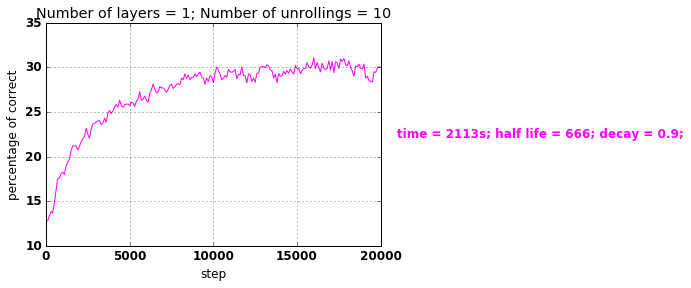

In [17]:
model.plot([0], save=True, save_folder='random_memory_hint')

In [46]:
num_unrollings_values = [10, 20, 30]
swap_probability_values = [0.6, 0.5, 0.4, 0.3, 0.2, 0.15, 0.1, 0.07, 0.05, 0.03]
results_GL = list()
for num_unrollings_value in num_unrollings_values:
    print("\n", ' '*5, "num unrollings: ", num_unrollings_value)
    for swap_probability_value in swap_probability_values:
        print("\nswap probability: ", swap_probability_value)
        model = random_memory_hint(64,
                         vocabulary,
                         characters_positions_in_vocabulary,
                         num_unrollings_value,
                         1,
                         [128],
                             swap_probability_value,
                           [37000, 39000],
                           0.997,                             
                         train_text,
                         valid_text)
        model.simple_run(100,
                       'random_memory_hint/nn128/variables/nu%s_sw%s' % (num_unrollings_value, swap_probability_value),
                       40000,
                       4000,
                       5000,        #learning has a chance to be stopped after every block of steps
                       30,
                       0.9,
                       3)
        results_GL.extend(model._results)
        model.destroy()
        del model
        gc.collect()


       num unrollings:  10

swap probability:  0.6
Number of steps = 40001     Percentage = 32.06%     Time = 522s     Learning rate = 0.0212

swap probability:  0.5
Number of steps = 40001     Percentage = 32.48%     Time = 524s     Learning rate = 0.0212

swap probability:  0.4
Number of steps = 40001     Percentage = 31.27%     Time = 519s     Learning rate = 0.0212

swap probability:  0.3
Number of steps = 40001     Percentage = 32.93%     Time = 516s     Learning rate = 0.0212

swap probability:  0.2
Number of steps = 40001     Percentage = 30.98%     Time = 516s     Learning rate = 0.0212

swap probability:  0.15
Number of steps = 40001     Percentage = 32.81%     Time = 514s     Learning rate = 0.0212

swap probability:  0.1
Number of steps = 40001     Percentage = 32.80%     Time = 511s     Learning rate = 0.0212

swap probability:  0.07
Number of steps = 40001     Percentage = 31.96%     Time = 512s     Learning rate = 0.0212

swap probability:  0.05
Number of steps = 40001  

In [47]:
folder_name = 'random_memory_hint'
file_name = 'random_memory_hint_ns_40000_hl_1333_dc_0.9_nu_10-30_sw_0.03-0.6_ilr0.5.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling random_memory_hint/random_memory_hint_ns_40000_hl_1333_dc_0.9_nu_10-30_sw_0.03-0.6_ilr0.5.pickle.


In [8]:
folder_name = 'random_memory_hint'
pickle_file = 'random_memory_hint_ns_40000_hl_1333_dc_0.9_nu_10-30_sw_0.03-0.6_ilr0.5.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [9]:
from plot_module import ComparePlots

random_memory_hint_plots = ComparePlots('random_memory_hint')
random_memory_hint_plots.add_network(results_GL, model._indices)



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


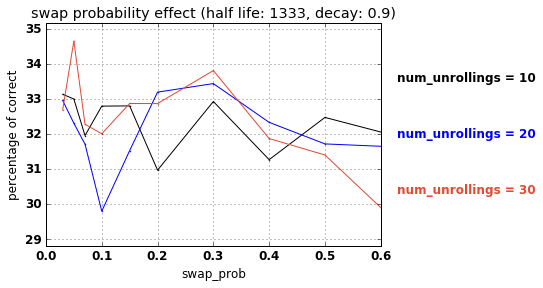

In [10]:
plot_data, _ = random_memory_hint_plots.one_key_layout_data('random_memory_hint_1',
                                         "swap_prob",
                                         'num_unrollings')
random_memory_hint_plots.save_layout(plot_data[0],
                    'swap probability effect (half life: 1333, decay: 0.9)',
                    ['swap_unrollings_effect', 'plots'],
                    'nn128;ns40000;hl1333;dc0.9')
random_memory_hint_plots.draw(plot_data[0], 'swap probability effect (half life: 1333, decay: 0.9)')

In [6]:
import random
class a(object):
    def __init__(self):
        self.b=0
    def set(self):
        self.b=random.randint(-2*10**9, 2*10**9)
        
for i in range(6):
    cl=a()
    cl.set()
    print(cl.b)
    del cl


528402069
81588369
138697545
1511835304
-43384984
-1061111843


In [4]:
for i in range(6):
    print(random.randint(-2*10**9, 2*10**9))

-851786402
-387582062
-1650398927
185292171
-704799417
475910726
